In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import math
import scipy as sp
import sys
from sys import getsizeof
from numpy.polynomial.chebyshev import Chebyshev as Cheb
from numpy.random import rand
from scipy.signal import tukey
import time
import corner
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

sns.set_context('talk')
sns.set_style('ticks')

import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms as T

import bilby

# Reproducibility

Setting the seed for the random number generators, this allows us to create reproduceable results using this particular seed, rather than it being randomised every time

In [2]:
seed =  1234

np.random.seed(seed)
torch.random.manual_seed(seed)


# Define model

In [3]:
# Defining the base class to build the neural network from, the neural networks inherets from nn.module (the base class for all neural networks in pytorch)
class ImprovedRealNVP(torch.nn.Module):
    
    #The __init__ function is executed when the class is initiated, It allows us to input properties of the class
    def __init__(self, 
    
                n_dims=None, # Number of inputs for the distribution to learn
                n_transforms=None, # Number of transforms to use
                n_layers_per_transform=None, # Number of layers in the neural network used for each transform
                n_neurons_per_layer=None, # Number of neurons per layer in the neural network
                n_conditional_inputs=None): # Chosing the conditions for which to base the new sampels(?)
        
        # Initialising the base class, nn.module along with the first __init__ for our ImprovedRealNVP Class.
        # Without super().__init__() we only inherent the methods of the base class, we need to use super init to run the init of the base class
        super().__init__() 
        
        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=n_conditional_inputs,
                    num_blocks=n_layers_per_transform,
                    activation=F.leaky_relu,
                    dropout_probability=False,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x, context=None):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x, context=context)

    def inverse(self, z, context=None):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z, context=context)

    def log_prob(self, x, context=None):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x, context=context)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n, context=None):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z, context=context)
        return samples

In [4]:
# Set the parameters for the flow, these are traditionally set to factors of 4 (4, 8, 16, 32, 64, etc)
flow = ImprovedRealNVP(
        n_dims=88, 
        n_transforms=4, 
        n_layers_per_transform=4, 
        n_neurons_per_layer=64, 
        n_conditional_inputs=256)

flow.to('cuda') #Run the flow using GPU

# Defining the optimiser used for training the flow
#
# Adam is used as a replacement optimiser for gradient descent
optimiser = torch.optim.Adam(flow.parameters(), # Returns the learnable parameters of the flow, 
                             lr=1e-3, # Learning rate
                             weight_decay=1e-6) # Adding an l2 regularization term to the loss

# Configure training parameters
n_epochs = 500 # Number of times the dataset is ran through the training algorithm
patience = 50 # The number of epochs after the loss no stops decreasing
batch_size = 500 # The number of samples used per epoch to train the dataset

# Dynamics

Under the assumptiob that the sources are modelled as point like particles and the dynamical evolution is restricted to 1D, the quaropole moment reduces to:

$Q(t) = \frac{1}{2} \sum_{i = 1}^{n} m_i x^2_i(t)$ at time $t$ for a system of $n$ particles each with mass $m_i$ and position $x_i(t)$

So to describe the dynamics we need values for position at a given time as well as the mass of each particles in the source

The mass is generated from a uniform distribution over the interval $[0,1]$ and rescale so that $M = \sum_{i=1}^n, m_i = 1$. We keep the total mass of a sample constant across the training set.

For modelling position we use a polynomial series, in particular, chebyshev polynomials of the first kind

In [5]:
# Defining the function to generate the chebyshev polynomial series
def dynamics_generation(PolyOrder, sampling):
  # Generating 0 matrices of the chosen chebychev polynomial order for each dimension
    x_coefs = np.zeros(PolyOrder)
    y_coefs = np.zeros(PolyOrder)
    z_coefs = np.zeros(PolyOrder)

    time = np.arange(-1,1,(2/sampling)) # Time interval centered around 0, with a size equal to the sample rate

    for i in range(0,PolyOrder):
    # Generating coefficients from a uniform distribution in range [-1,1]
        x_coefs[i] = (2*rand())-1 
        #rand() returns a value in the range of 0 to 1, so to get a range of -1 to 1 we multiply by 2 and subtract by 1
    return x_coefs, time # Returns the x coefficients as well as the time across the waveform

With our assumptions, the equation for strain is given by $h(t) \approx \frac{d^2Q}{dt^2} = \sum_{i=1}^{n} m_i(\dot x_i^2(t) + x_i(t)\ddot x_i(t))$

This shows us that the mass and position are not uniquley defined when determining the strain value, so there will be some degeracy, different positions and masses can produce the same strain. 

We also want to window our mass dynamics to generate the burst dyamics we are discussing, so our masses will start at 0, do some movement, and return to 0. So this will encorporate the window function in our strain calulation, meaning we need to compute product rule and chain rule as the window function depends on $x$, and $x$ depends on $t$

## Window Function

$$ w(x)=   \left\{
\begin{array}{ll}
      \frac{1}{2} (1 + cos\left(\frac{2 \pi}{\alpha} [x - \frac{\alpha}{2}]\right) & 0 \leq x \leq \frac{\alpha}{2} \\
      1 & \frac{\alpha}{2} \leq x \leq 1 - \frac{\alpha}{2} \\
      \frac{1}{2} (1 + cos\left(\frac{2 \pi}{\alpha} [x - \frac{\alpha}{2}]\right) & 1 - \frac{\alpha}{2} \leq x \leq 1 \\
\end{array} 
\right.  $$

$$ w'(x)=   \left\{
\begin{array}{ll}
      - \frac{1}{a}\pi sin(\frac{2 \pi x}{a} - \pi) & 0 \leq x \leq \frac{\alpha}{2} \\
      1 & \frac{\alpha}{2} \leq x \leq 1 - \frac{\alpha}{2} \\
      - \frac{1}{a}\pi sin(\frac{2 \pi x}{a} - \pi) & 1 - \frac{\alpha}{2} \leq x \leq 1 \\
\end{array} 
\right.  $$

$$ w''(x)=   \left\{
\begin{array}{ll}
      - \frac{1}{a^2}2 \pi^2 cos(\frac{2 \pi x}{a} - \pi) & 0 \leq x \leq \frac{\alpha}{2} \\
      1 & \frac{\alpha}{2} \leq x \leq 1 - \frac{\alpha}{2} \\
      - \frac{1}{a^2}2 \pi^2 cos(\frac{2 \pi x}{a} - \pi) & 1 - \frac{\alpha}{2} \leq x \leq 1 \\
\end{array} 
\right.  $$

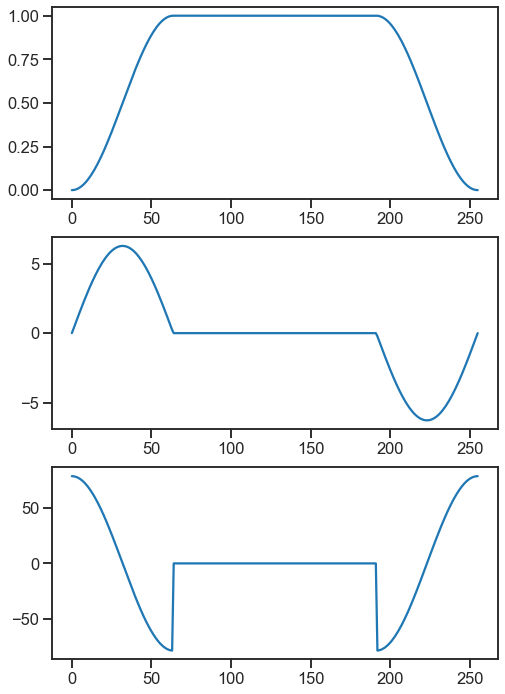

In [6]:
# Defining a function to compute the Tukey function and its derivatives as above

def tukey_win(sample_points, alpha = 0.5):
    
    y = []
    
    # Using a loop to iterate over a linear array of len of sample rate in order to generate the piecewise function
    
    for i in np.linspace(0, sample_points, sample_points):
        if i <= alpha/2 * sample_points:
            y_new = 0.5 * (1 + np.cos(((2 * np.pi) / alpha) * (i - (alpha / 2)))) 

        elif alpha/2 * 256 <= i <= (1 - (alpha/2)) * 256:
             y_new = 1

        elif i >= (1 - (alpha/2)) * 256:
            y_new = 0.5 * (1 + np.cos(((2 * np.pi) / alpha) * (i - (alpha / 2)))) 

        y.append(y_new)
    
    y_der1 = []

    for i in np.linspace(0, sample_points, sample_points):
        if i <= alpha/2 * sample_points:
            y_new = -(1 / alpha) * np.pi * np.sin(((2 * np.pi * i) / alpha) - np.pi)

        elif alpha/2 * 256 <= i <= (1 - (alpha/2)) * 256:
             y_new = 0

        elif i >= (1 - (alpha/2)) * 256:
            y_new = -(1 / alpha) * np.pi * np.sin(((2 * np.pi * i) / alpha) - np.pi)

        y_der1.append(y_new)
        
    y_der2 = []

    for i in np.linspace(0, sample_points, sample_points):
        if i <= alpha/2 * sample_points:
            y_new = -(1 / alpha**2) * 2 * np.pi**2 * np.cos(((2 * np.pi * i) / alpha) - np.pi)

        elif alpha/2 * 256 <= i <= (1 - (alpha/2)) * 256:
             y_new = 0

        elif i >= (1 - (alpha/2)) * 256:
            y_new = -(1 / alpha**2) * 2 * np.pi**2 * np.cos(((2 * np.pi * i) / alpha) - np.pi)

        y_der2.append(y_new)
        
    return y, y_der1, y_der2 # Returns the orginal window as well as its first and second derivatives

y, y1, y2 = tukey_win(256)


plt.figure(figsize = [8,12])

plt.subplot(311)
plt.plot(y)

plt.subplot(312)
plt.plot(y1)

plt.subplot(313)
plt.plot(y2)
plt.show()

In [167]:
# Apply a window function so that our generated strain tapers to zero at t = 0, t = 1
window, window_der1, window_der2 = tukey_win(256) # Using the tukey window function with 256 points, matching our sampling rate, and returning 1st and 2nd derivatives

#Defining a function to perform the operations to the chebyshev series as shown above
def strain(total_dynamics):
    coefsq = np.polynomial.chebyshev.chebpow(total_dynamics, 2) # Raise a chebyshev series (total_dynanmics) to a power (2) 
    sqrdif2 = np.polynomial.chebyshev.chebder(coefsq, 2) # Differentiate a chebyshev series (coefsq) to a given order (2) 
  
    return sqrdif2

# QUESTION: inconsistent with above equation?

In [168]:
def mass_generation(nummass):
  #Generating masses from a Dirichlet distribution - looks like a uniform distribution 
    masses = np.zeros(nummass)
    for n in range(0, nummass):
        masses[n] = np.random.rand()

    masses = masses/np.sum(masses) # Applying scaling so the total mass = 1, keeping it constant throughout 

    return masses

In [169]:
#Defining the function to generate the data
def data_generation(ChebOrder, nummass, numsamples, samplerate = 256):
# ChebOrder - Order N of Chebyshev Polynomials T_N comprising series
# nummass - Number of masses
# numsamples - Number of Training Samples
# samplerate - Sampling rate (default 256 samples)

    hCoefs = np.zeros((numsamples, (ChebOrder*2)-3)) # QUESTION: where does this come from?
    all_masses = np.zeros((numsamples, nummass)) # Array holding the masses along the columns with each row being a sample
    
    # We Generate a flattened Array holding the masses and chebyshev order in the columns, this way when we reshape the array,
    #  for a given sample we will have a number of masses x chebyshev order array from which we can generate the mass dynamics from 
    flattened_dynamics = np.zeros((numsamples, (nummass*ChebOrder))) 
    
    # Creating this empty array to be used once we create the dynamics and can concatonate with the masses so we can relate them
    flat_samples = np.zeros((numsamples, (nummass*ChebOrder))) 
    
    # Generating timeseries array with each sample on a column and each row holding the number of points in that sample
    h_tseries = np.zeros((numsamples, samplerate)) 
    
    # Creating seperate arrays of the strain timeseries that will not have the window function or any scaling applied 
    # QUESTION: Why do this? Is this still useful in the current state of the code?
    h_tseries_noTukey = np.zeros((numsamples, samplerate))
    h_tseries_unscaled = np.zeros((numsamples, samplerate))

    for sample in range(0, numsamples):

        overall_dynamics = np.zeros(ChebOrder)
        overall_strain = np.zeros((ChebOrder*2)-3)
        mass_values = mass_generation(nummass)
        all_masses[sample, :] = mass_values

        for mass in range(0, nummass):

            b, sampling_points = dynamics_generation(ChebOrder, samplerate)
            flattened_dynamics[sample, (len(b)*mass):(len(b)*(mass + 1))] = b
            b_strain = strain(b)
            overall_strain = np.add(overall_strain, mass_values[mass]*b_strain)
            overall_dynamics = np.add(overall_dynamics,(mass_values[mass]*np.array(b)))

        hCoefs[sample, :] = strain(overall_dynamics)

        #Producing strain timeseries from coefficients of strain
        h_tseries_noTukey[sample, :] = np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
        h_tseries[sample, :] = window * np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
        #experiment
   

    h_tseries_unscaled = h_tseries
    h_tseries = h_tseries/np.abs(np.max(h_tseries)) #/abs max

  
    flat_samples = np.concatenate((flattened_dynamics, all_masses), axis=1)

    return all_masses, sampling_points, h_tseries, flat_samples, h_tseries_unscaled, h_tseries_noTukey 

# Data Generation

In [170]:
start_time = time.time()
totalSamples = 400000
massnum = 8
Order = 10

curveweights, sample_len, HTseries, flat_samples, HTseries_unscaled, HTseries_unwindowed = data_generation(Order, massnum, totalSamples)

elapsed_time = time.time() - start_time

print(elapsed_time)

328.64464259147644


In [172]:
np.shape(flattened_dynamics)

NameError: name 'flattened_dynamics' is not defined

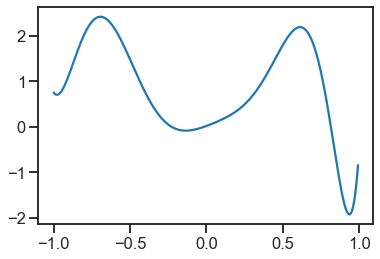

In [67]:
np.shape(flat_samples)

sample_1 = flat_samples[0,:]

np.shape(sample_1)

sample_1_dyn = sample_1[0:(len(sample_1)-massnum)]

np.shape(sample_1_dyn)

unflattened_sample = sample_1_dyn.reshape((massnum, Order))

np.shape(unflattened_sample)

t = np.arange(-1,1,(2/256))

source_tseries = np.polynomial.chebyshev.chebval(t, unflattened_sample[4, :])

plt.plot(t, source_tseries)

In [11]:
gaussian_noise = np.random.normal(0, 0.05, np.shape(HTseries))
h_tseries_noise = HTseries + gaussian_noise

In [12]:
samples_tensor = torch.Tensor(flat_samples)
tensor_strain = torch.Tensor(h_tseries_noise)

my_dataset = TensorDataset(samples_tensor, tensor_strain)

train_set, val_set = train_test_split(my_dataset, test_size = 0.1)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Train

In [ ]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for batch_num,(x_tensor, labels) in enumerate(train_loader):
        x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
        # labels = one_hot(labels, 10)
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor, context=labels).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    val_loss = 0
    with torch.no_grad():
        flow.eval()
        for batch_num,(x_tensor, labels) in enumerate(test_loader):
            x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
            # labels = one_hot(labels, 10)
            val_loss += -flow.log_prob(x_tensor, context=labels).mean().cpu().numpy()
    val_loss /= len(test_loader)

    loss_dict['val'].append(val_loss)

    # Save the best model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print(f'Epoch {best_epoch} val loss: {best_val_loss:1.4f}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

# Loss Plots

In [13]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves with 400,000 samples')
plt.yscale('symlog')
plt.show()

NameError: name 'loss_dict' is not defined

In [ ]:
print(np.shape(zarray))

plt.plot(zarray[:750,0])
plt.show()

for z_values in zarray.T:
    #z_values = zarray[:,i]A
    plt.hist(z_values , bins = np.linspace(-5,5,250), density = False, histtype = 'step')

mu, sigma = 0, 1
x = mu + sigma*np.random.randn(40000)

x_vec = np.linspace(-5,5,100)
r = norm.pdf(x_vec, loc = 0, scale = 1)

#plt.plot(x_vec,r, '-k')

plt.show()

# Saving and Loading Model

In [96]:
torch.save(flow.state_dict(), 'model.pt')
torch.save(optimiser.state_dict(), 'optimiser.pt')

In [ ]:
flow.load_state_dict(torch.load('model.pt'))
flow.eval()

# Sample Generation

In [14]:
with torch.no_grad():
    x, c = next(iter(test_loader))

C:\Users\User\Anaconda3\lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


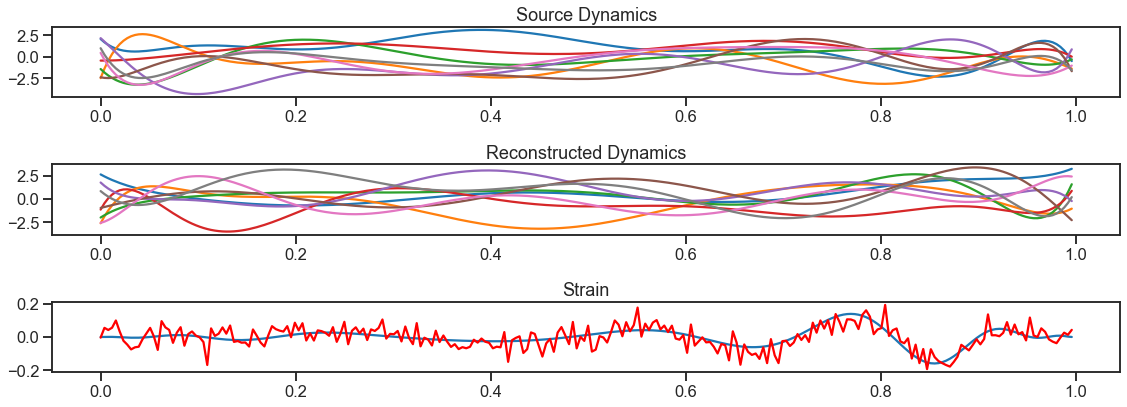

In [15]:
with torch.no_grad():
    x = x[0].unsqueeze(0) 
    c = c[0] 
    x_out = flow.sample(1, c.unsqueeze(0).to('cuda')).cpu().numpy()
    source = x.detach().cpu().numpy().squeeze()
    
    source_dyn = source[0:(len(source)-massnum)]
    source_dyn_unflattened = source_dyn.reshape((massnum, Order))
    recon = x_out.squeeze()
    
    
    recon_dyn = recon[0:(len(recon)-massnum)]
    recon_dyn_unflattened = recon_dyn.reshape((massnum, Order))
    t = np.arange(-1,1,(2/256))
    t_shifted = np.arange(0,1,(1/256))
    c = c.cpu().squeeze()
    recon_summed_dyn = np.zeros(Order)
    source_summed_dyn = np.zeros(Order)
    recon_weights = recon[(len(recon)-massnum):len(recon)]
    
    source_weights = source[(len(source)-massnum):len(source)]
    overall_recon_strain = np.zeros((Order*2)-3)

    size = (16,6)
    fig, axes = plt.subplots(3, 1, figsize=size)

    for mass in range(0, massnum):
        source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
        recon_tseries = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened[mass, :])
        axes[0].plot(t_shifted, source_tseries, label=mass)
        axes[1].plot(t_shifted, recon_tseries, label=mass)
        recon_summed_dyn += (recon_dyn_unflattened[mass, :] * recon_weights[mass])
      
      
      

    
    recon_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
    recon_hcoefs = np.polynomial.chebyshev.chebder(recon_coefsq,2)
    recon_htseries = window * np.polynomial.chebyshev.chebval(t, recon_hcoefs)

    
    recon_htseries = recon_htseries / np.abs(np.max(HTseries_unscaled))
#h_tseries/np.abs(np.max(h_tseries))
    axes[0].set_title("Source Dynamics")
    axes[1].set_title("Reconstructed Dynamics")
    axes[2].set_title("Strain")
    axes[2].plot(t_shifted, recon_htseries)
    axes[2].plot(t_shifted, c, color='r')

    

fig.subplots_adjust()
fig.tight_layout()
plt.show()

In [16]:
c = c.unsqueeze(0)

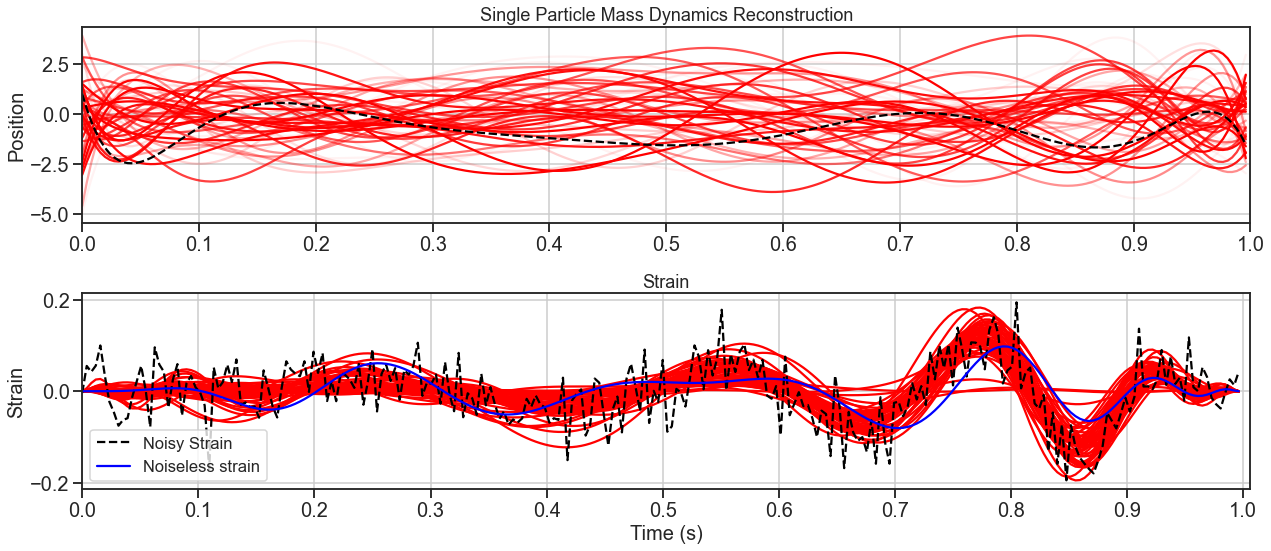

In [20]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
source_tseries_array = np.zeros((8,256))
t_shifted = np.arange(0,1,(1/256))

plt.setp(axes, xlim=(0,np.max(t_shifted+0.01)))

with torch.no_grad():
    for j in range (0,50):
        recon_summed_dyn = np.zeros(Order)
        x_out = flow.sample(1, c.to('cuda')).cpu().numpy()
        recon = x_out.squeeze()
        recon_dyn = recon[0:(len(recon)-massnum)]
        recon_unflattened_dyn = recon_dyn.reshape((massnum, Order))
        recon_weights = recon[(len(recon)-massnum):len(recon)]
        recon_weights_rescaled = (0.95*((recon_weights - np.min(recon_weights))/(np.max(recon_weights) - np.min(recon_weights))))+0.05
        source_weights_rescaled = (0.95*((source_weights - np.min(source_weights))/(np.max(source_weights) - np.min(source_weights))))+0.05
        for mass in range(0, 8):
        #Use random latent space point z to produce multiple possible dynamics for a single strain
            recon_tseries = np.polynomial.chebyshev.chebval(t, recon_unflattened_dyn[mass, :])
   
            if mass == 0:
                axes[mass].plot(t_shifted, recon_tseries, color='r', alpha = recon_weights_rescaled[mass])
                axes[mass].set_xlim([0, np.max(t_shifted)])
            recon_summed_dyn += (recon_unflattened_dyn[mass, :] * recon_weights[mass])

        x_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
        x_hcoefs = np.polynomial.chebyshev.chebder(x_coefsq,2)
        recon_htseries = window * np.polynomial.chebyshev.chebval(t, x_hcoefs)
        recon_htseries = recon_htseries / np.abs(np.max(HTseries_unscaled))
        
        axes[1].plot(t_shifted, recon_htseries, 'r')
    axes[1].plot(t_shifted, c.squeeze(), color='k', ls='--', label = 'Noisy Strain')
    h_sample_1 = HTseries[360000,:]
    axes[1].plot(t_shifted, h_sample_1, color='b', ls='-', label = 'Noiseless strain')

    for mass in range(0, 8):
        source_tseries_array[mass,:] = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
        source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
    axes[0].plot(t_shifted, source_tseries, 'k--')
      
    fig.subplots_adjust()
    fig.tight_layout()
    axes[0].set_xticks(np.arange(0,1.01,0.1))
    axes[1].set_xticks(np.arange(0,1.01,0.1))
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    axes[0].grid(b=bool)
    axes[1].grid(b=bool)
    axes[1].set_xlabel('Time (s)', fontsize=20)
    axes[0].set_ylabel('Position', fontsize=20)
    axes[1].set_ylabel('Strain', fontsize=20)
    
    axes[0].set_title("Single Particle Mass Dynamics Reconstruction")
    axes[1].set_title("Strain")
    
    plt.legend()
    fig.tight_layout()
    plt.show()

In [21]:
sigma = 0.05
snr = []
for n in np.arange(0, totalSamples):
    snr_squared = np.sum((HTseries[n,:])**2) / sigma**2
    snr.append(np.sqrt(snr_squared))

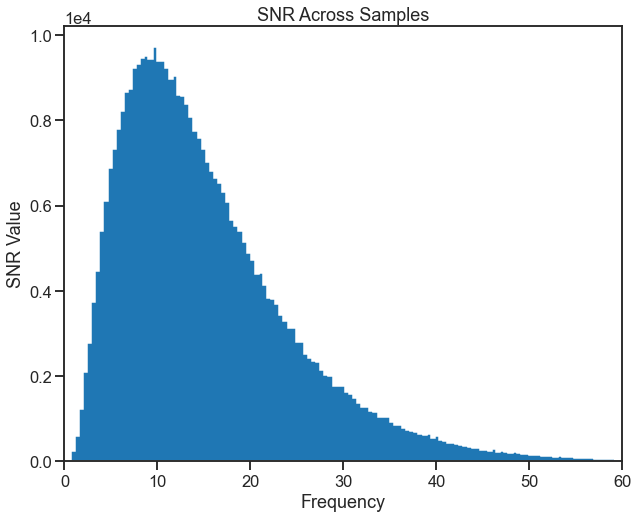

In [22]:
plt.figure(figsize = [10,8])
plt.title('SNR Across Samples')
plt.hist(snr, bins = 250, histtype='stepfilled')
plt.xlabel('Frequency')
plt.ylabel('SNR Value')
plt.xlim(0,60)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

## P-P Plot

In [ ]:
bilby.result.Result()

# Plotting Latent Space

# Animation

In [21]:
%matplotlib inline

In [22]:
from matplotlib import animation, rc
from IPython.display import HTML

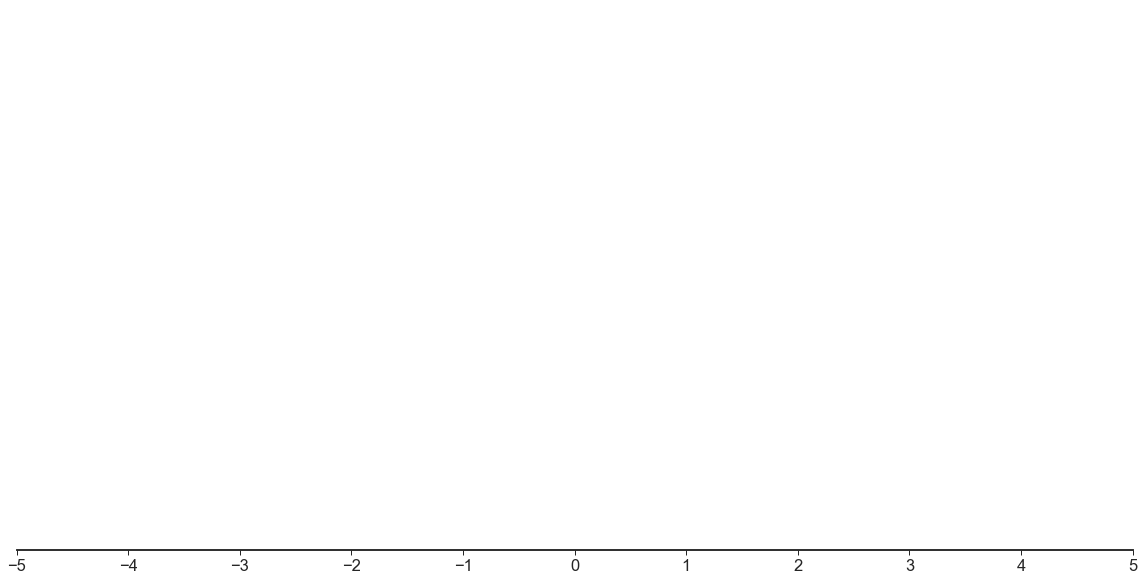

In [23]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20,10))

ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.patch.set_alpha(0.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.NullLocator())
plt.gca()
ax.set_facecolor((0.5, 0.5, 0.5))
scat = ax.scatter([[]],[[]], cmap='hsv', alpha=0.6)


In [24]:
#source_tseries_array

def init():
    scat = ax.scatter([[]],[[]],cmap='hsv', alpha=0.6)
    return scat,


In [25]:
def animate(i):
  scat.set_offsets(np.vstack((source_tseries_array[:, i], [0.07]*8)).T)
  scat.set_sizes(source_weights * 20000)
  scat.set_array(np.arange(8))
  return scat,

In [26]:
# call the animator. blit=True means only re-draw the parts that have changed
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=256, interval=40)

In [27]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available